In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [7]:
data_dir=r"./pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [8]:
#  preprocess data
def line(filename):
  '''Reads filename and returns lines of text in that file as a list. '''
  with (open(filename,"r")) as f:
    return f.readlines()

In [9]:
import zipfile
zip=zipfile.ZipFile(data_dir+"train.zip")
zip.extractall()
zip.close()

In [10]:
train_lines=line("train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [11]:
len(train_lines)

2593169

In [12]:
def preprocess_text(filename):
  lines=line(filename)
  abstract_data=[]
  count=0
  for abs_line in lines:
    if abs_line.startswith("###"):
      abstract_id=abs_line

    elif abs_line.isspace()==False:
      line_data={}
      target_text=abs_line.split("\t")
      line_data["line_number"]=count
      line_data["target"]=target_text[0]
      line_data["text"]=target_text[1].lower()
      abstract_data.append(line_data)
      count+=1

    else:
      total=count
      for a in abstract_data[-total:len(abstract_data)]:
        a["total_lines"]=total
      count=0

  return abstract_data

In [13]:
%%time
train_samples=preprocess_text("train.txt")
test_samples=preprocess_text(data_dir+"test.txt")
val_samples=preprocess_text(data_dir+"dev.txt")
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 2.64 s, sys: 860 ms, total: 3.5 s
Wall time: 3.5 s


(2211861, 28932, 29493)

In [14]:
train_samples[:15]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .\n',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .\n',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .\n",
  'total_lines': 11},
 {'line_number': 4

In [15]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)
train_df

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,11
1,1,BACKGROUND,this paper describes the design and evaluation...,11
2,2,METHODS,this study is designed as a randomised control...,11
3,3,METHODS,the intervention group will participate in the...,11
4,4,METHODS,the program is based on self-efficacy theory a...,11
...,...,...,...,...
2211856,5,METHODS,"after crossover , the wait-list group received...",10
2211857,6,METHODS,performance was assessed by comparison to amer...,10
2211858,7,RESULTS,performance improved significantly after simul...,10
2211859,8,RESULTS,no improvement was detected as a function of c...,10


In [16]:
train_df.target.value_counts()

,count
target,
RESULTS,766271
METHODS,722586
CONCLUSIONS,339714
BACKGROUND,196689
OBJECTIVE,186601


In [17]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .\n',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .\n',
 "the intervention group will participate in the online group program ` positive outlook ' .\n",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .\n']

In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse_output=False)
train_label_encoded=encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_label_encoded=encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_encoded=encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_label_encoded

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [20]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
train_label_encode=encoder.fit_transform(train_df["target"].to_numpy())
test_label_encode=encoder.transform(test_df["target"].to_numpy())
val_label_encode=encoder.transform(val_df["target"].to_numpy())

train_label_encode

array([0, 0, 2, ..., 4, 4, 4])

In [21]:
encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

> ### Baseline model: TF-IDF Multinomial Naive Bayes classifier

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model0=Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model0.fit(train_sentences,train_label_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
model0.score(val_sentences,val_label_encode)

0.7497580533665146

In [24]:
from joblib import dump
dump(model0,"model0.joblib")

['model0.joblib']

In [25]:
y_pred0=model0.predict(val_sentences)
y_pred0

array([0, 4, 4, ..., 4, 4, 1])

In [26]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def result(y_true,y_pred):
  accuracy=accuracy_score(y_true,y_pred)*100
  precision,recall,f1_score,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_result={
      "accuracy":accuracy,
      "precision":precision,
      "reacall":recall,
      "f1-score": f1_score
  }
  return model_result


In [27]:
from joblib import load
model0 = load('model0.joblib')

In [28]:
model0_results=result(val_label_encode,y_pred0)
model0_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'reacall': 0.7497580533665146,
 'f1-score': 0.7389570175489825}

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [30]:
#  how long are the sentenceson average
sent=[len(sentence.split()) for sentence in train_sentences]
np.mean(sent)

26.229355280462922

>> **We need to take care of sentence length we set for vectorization layer as too short will lead to loss of info and too large will create a large dataset having just zeroes on every sentence's head and tail.**

In [31]:
#  how long sentence length is for 95% of trainin set
int (np.percentile(sent,95))

54

In [32]:
max(sent)

338

In [33]:
from tensorflow.keras.layers import TextVectorization
# in paper it is given that for 20k dataset max vocab is 68k.
text_vectorizer=TextVectorization(max_tokens=331000,
                                  output_sequence_length=54)

In [34]:
text_vectorizer.adapt(train_sentences)

In [35]:
import random
target_sentence=random.choice(train_sentences)
print(f"Text: \n {target_sentence}")
print(f"Length of text: {len(target_sentence.split())}")
print(f"Vectorized text: {text_vectorizer(target_sentence)}")

Text: 
 however , results from clinical trials have not been published .

Length of text: 11
Vectorized text: [ 140  106   29   48  302   96   27  149 2070    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [36]:
rct_200k=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_200k)}")
print(f"Most common words: {rct_200k[:5]}")
print(f"Least common words: {rct_200k[:-5]}")

Number of words in vocab: 247961
Most common words: ['', '[UNK]', 'the', 'of', 'and']
Least common words: ['', '[UNK]', 'the', 'of', 'and', 'in', 'to', 'with', 'a', 'were', 'was', 'patients', 'for', 'group', 'p', 'or', 'at', 'treatment', 'study', 'on', 'after', 'by', 'is', 'groups', 'this', 'as', 'that', 'not', 'no', 'from', 'an', 'randomized', 'between', 'significant', 'significantly', 'compared', 'than', 'placebo', 'control', 'be', 'n', 'trial', 'months', 'mg', 'during', 'two', 'both', 'had', 'clinical', 'mean', 'vs', 'there', 'therapy', 'baseline', 'all', 'weeks', 'we', 'intervention', 'effects', 'more', 'time', 'pain', 'effect', 'who', 'years', 'but', 'using', 'are', 'rate', 'days', 'received', 'subjects', 'women', 'total', 'respectively', 'difference', 'one', 'levels', 'efficacy', 'blood', 'ci', 'primary', 'risk', 'increased', 'use', 'higher', 'may', 'randomly', 'associated', 'day', 'differences', 'these', 'used', 'dose', 'either', 'care', 'have', 'week', 'did', 'lower', 'surgery'

***In this we got vocab length to be less than max_tokens which means that vectorizer has covered every unique word and mapped it to integers.***
> But why do we got differnt value than given in paper?
>>Its because we are here using replaced with @ text files

> ### Embedding layer

In [37]:
token_embed=layers.Embedding(input_dim=len(rct_200k),
                             output_dim=128,
                             mask_zero=True, # it is basically used to improve computing power comes in handy if we have lots of zeros due to padding)
                             name="token_embedding")

In [38]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence=text_vectorizer(target_sentence)
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape:\n {embedded_sentence.shape}")
#  as the layer is not trained we can see that last values i.e zero in vectorized part are same in embedded sentence.

Sentence before vectorization:
 however , results from clinical trials have not been published .


Sentence after vectorization:
 [ 140  106   29   48  302   96   27  149 2070    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]

Sentence after embedding:
 [[-0.00033122 -0.03103887  0.00920582 ...  0.02128155 -0.02651746
  -0.03464754]
 [ 0.02676935 -0.00885937  0.01516041 ... -0.04607376  0.0069898
  -0.02370414]
 [-0.01666724 -0.02635707 -0.01639628 ...  0.00449915  0.03381691
  -0.02328931]
 ...
 [ 0.04478891 -0.03979351 -0.02479688 ... -0.04825215 -0.00408273
  -0.00289584]
 [ 0.04478891 -0.03979351 -0.02479688 ... -0.04825215 -0.00408273
  -0.00289584]
 [ 0.04478891 -0.03979351 -0.02479688 ... -0.04825215 -0.00408273
  -0.00289584]]

Embedded sentence shape:
 (54, 128)


In [39]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_label_encoded))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_label_encoded))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_label_encoded))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# we are not shuffling our data here as we want it to learn the sequence of their occurences
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

> ### Model1: Conv1D

In [41]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)
model1=tf.keras.Model(inputs,outputs)

model1.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [42]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 54)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 54, 128)             │      31,739,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 54, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,780,357 (121.23 MB)

 Trainable params: 31,780,357 (121.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
len(train_dataset)

69121

In [ ]:
history1=model1.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3,
                    steps_per_epoch=int(0.1*len(train_dataset)), # this is used to determine whether everything is right or not in our starting experiments, int this it takes some amount of dataset in each epoch
                    validation_steps=int(0.2*len(val_dataset)))
#  now we can see that it runs on just 562 batches i.e. 10% of train_dataset per epoch

Epoch 1/3


6912/6912 [==============================] - 210s 29ms/step - loss: 0.5891 - accuracy: 0.7890 - val_loss: 0.4849 - val_accuracy: 0.8298
Epoch 2/3
6912/6912 [==============================] - 199s 29ms/step - loss: 0.5023 - accuracy: 0.8224 - val_loss: 0.4548 - val_accuracy: 0.8444
Epoch 3/3
6912/6912 [==============================] - 198s 29ms/step - loss: 0.4808 - accuracy: 0.8296 - val_loss: 0.4442 - val_accuracy: 0.8467


In [ ]:
model1.save("model1")

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


In [ ]:
model1 = tf.keras.models.load_model("model1")

In [ ]:
y_pred1=model1.predict(val_dataset)
y_pred1

905/905 [==============================] - 5s 3ms/step


array([[9.0245187e-01, 2.5772825e-03, 6.5829213e-06, 9.4961151e-02,
        3.0013468e-06],
       [1.8614782e-02, 1.2834122e-02, 8.2998651e-01, 1.4128957e-02,
        1.2443563e-01],
       [1.2724117e-03, 1.0644332e-01, 4.6981680e-03, 3.6924484e-04,
        8.8721687e-01],
       ...,
       [4.4417204e-04, 3.3921969e-01, 1.7264574e-04, 1.1678509e-04,
        6.6004676e-01],
       [1.1890889e-02, 2.7329823e-01, 4.3704603e-03, 4.6743518e-03,
        7.0576602e-01],
       [2.1872140e-01, 6.7462051e-01, 3.4852915e-03, 9.6761189e-02,
        6.4116023e-03]], dtype=float32)

In [ ]:
model1_preds=tf.argmax(y_pred1,axis=1)
model1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1], dtype=int64)>

In [ ]:
model1_results=result(val_label_encode,model1_preds)
model1_results

{'accuracy': 83.64786395686437,
 'precision': 0.8395469320977549,
 'reacall': 0.8364786395686438,
 'f1-score': 0.8344219306026673}

In [ ]:
import tensorflow_hub as hub
hub_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)
# pretrained embedding layer is in itself a layer it doesn't consist of any sublayers like pretrained models

In [ ]:
random_train_sentence=random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_sentence=hub_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_sentence[0][:30]}")
print(f"Length of embedding: {len(use_sentence[0])}")
# here total length for the sentence matrix is 512 after both tokenization and embedding process
# but in the previous case i.e. while creating our own embedding layer we first created tokenized vectors so its shape was [55,128]

Random Sentence:
 clinicaltrials.gov , nct@ .

Sentence after embedding:
 [ 0.06226593  0.0182669   0.09174655 -0.04007194 -0.01072718  0.0281311
 -0.02087801  0.00213062 -0.01701686  0.01388827 -0.01285874  0.00204266
  0.0249952  -0.00094792 -0.02459633  0.04537921  0.00602535 -0.05342493
  0.08895262 -0.04546617  0.03051196  0.05420276 -0.06814542 -0.06971154
 -0.00597266 -0.05979293 -0.07159757  0.0054745  -0.03327288  0.08589593]
Length of embedding: 512


> ### Model2: pretrained feature extraction



In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained=hub_layer(inputs)
x=layers.Dense(128,activation="relu")(pretrained)
outputs=layers.Dense(5,activation="softmax")(x)
model2=tf.keras.Model(inputs,outputs)

model2.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history2=model2.fit(train_dataset,
                    steps_per_epoch=int(0.1*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)),
                    epochs=3)

Epoch 1/3


6912/6912 [==============================] - 92s 13ms/step - loss: 0.7007 - accuracy: 0.7328 - val_loss: 0.6317 - val_accuracy: 0.7604
Epoch 2/3
6912/6912 [==============================] - 81s 12ms/step - loss: 0.6271 - accuracy: 0.7638 - val_loss: 0.6003 - val_accuracy: 0.7688
Epoch 3/3
6912/6912 [==============================] - 78s 11ms/step - loss: 0.6052 - accuracy: 0.7722 - val_loss: 0.5811 - val_accuracy: 0.7781


In [ ]:
model2.save("model2")

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


In [ ]:
with tf.device('/CPU:0'):
    model2 = tf.keras.models.load_model("model2")
    y_pred2=model2.predict(val_dataset)
    model2_preds=tf.argmax(y_pred2,axis=1)
    model2_results=result(val_label_encode,model2_preds)
    print(model2_results)

905/905 [==============================] - 7s 7ms/step
{'accuracy': 77.63030554403429, 'precision': 0.7736917064298356, 'reacall': 0.7763030554403428, 'f1-score': 0.7738829897195112}


> ### Model3: Conv1D with character embeddings

#### ``` creating character level tokenizer```




In [ ]:
" ".join(list(train_sentences[0]))

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   . \n'

In [ ]:
def split_char(text):
  return " ".join(list(text))

In [ ]:
train_chars=[split_char(sentence) for sentence in train_sentences]
val_chars=[split_char(sentence) for sentence in val_sentences]
test_chars=[split_char(sentence) for sentence in test_sentences]
train_chars[0]

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   . \n'

In [ ]:
# avg character length
import numpy as np
char_len=[len(sentence) for sentence in train_sentences]
np.mean(char_len)

148.76785337011736

In [ ]:
int(np.percentile(char_len,95))

284

In [ ]:
#  getting all keyboard characters for max_tokens
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
char_tokens=len(alphabet)+2 # add 2 for apace and oov
char_vectorizer=TextVectorization(max_tokens=char_tokens,
                                  # standardize=None,
                               output_sequence_length=285)
# text vectorizer now considers each and every single character as word as all characters are seperated by space thus making them a word for a sentence and have used parameters for letters in place of words.

In [ ]:
char_vectorizer.adapt(train_chars,batch_size=128)

In [ ]:
# for standarize=None

char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#  for standardize = punctuation and strip and it gives less vocab as it omits the punctuation and all

char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
import random
random_char=random.choice(train_chars)
print(f"Charified text:\n {random_char}")
print(f"Length of random_char: {len(random_char.split())}")
vectorized_char=char_vectorizer(random_char)
print(f"Vectorized char:\n {vectorized_char}")
print(f"Length of vectorized char: {len(vectorized_char)}")

Charified text:
 p a t i e n t s   r e c e i v i n g   h d   t h e r a p y   a c h i e v e d   a s t h m a   c o n t r o l   m o r e   r a p i d l y   a n d   m a i n t a i n e d   g r e a t e r   s t a b i l i t y   t h a n   t h o s e   r e c e i v i n g   g d   t h e r a p y   . 

Length of random_char: 115
Vectorized char:
 [14  4  3  5  2  6  3  9  8  2 12  2  5 21  5  6 18 13 10  3 13  2  8  4
 14 19  4 12 13  5  2 21  2 10  4  9  3 13 15  4 12  7  6  3  8  7 11 15
  7  8  2  8  4 14  5 10 11 19  4  6 10 15  4  5  6  3  4  5  6  2 10 18
  8  2  4  3  2  8  9  3  4 22  5 11  5  3 19  3 13  4  6  3 13  7  9  2
  8  2 12  2  5 21  5  6 18 18 10  3 13  2  8  4 14 19  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 

> #### character embedding



In [ ]:
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25, # size given in paper
                            mask_zero=True)

In [ ]:
print(f"Charified text:\n {random_char}")
charr_embed=char_embed(char_vectorizer(random_char))
print(f"Embedded char:\n {charr_embed}")
print(f"Character embedding shape: {charr_embed.shape}")

Charified text:
 t w o   t y p e s   o f   s u r g i c a l   t e c h n i q u e s   w e r e   b l i n d l y   a p p l i e d   i n   @   o b e s e   r e p r o d u c t i v e - a g e   w o m e n   w i t h   b e n i g n   n e o p l a s t i c   d i s e a s e s   o f   o v a r y   a n d   u t e r u s   . 

Embedded char:
 [[-0.03492744  0.04280504 -0.03079712 ... -0.03472454 -0.01087096
  -0.009333  ]
 [-0.03318164  0.03900725  0.01384851 ... -0.0276136   0.03850763
   0.03804268]
 [-0.00547744  0.01949686 -0.02075518 ... -0.01819478 -0.00994078
  -0.03332051]
 ...
 [ 0.02387032 -0.02204984 -0.04532174 ... -0.03666279  0.03588304
   0.00805478]
 [ 0.02387032 -0.02204984 -0.04532174 ... -0.03666279  0.03588304
   0.00805478]
 [ 0.02387032 -0.02204984 -0.04532174 ... -0.03666279  0.03588304
   0.00805478]]
Character embedding shape: (285, 25)


In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)
model3=tf.keras.Model(inputs,outputs)

model3.compile(loss="categorical_crossentropy",
               metrics=["accuracy"],
               optimizer="adam")

In [ ]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 285)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 285, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 285, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# creatting char level datasets

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history3=model3.fit(train_char_dataset,
                    validation_data=val_char_dataset,
                    epochs=3,
                    validation_steps=int(0.1*len(val_char_dataset)),
                    steps_per_epoch=int(0.1*len(train_char_dataset)))

Epoch 1/3


4082/4082 [==============================] - 89s 15ms/step - loss: 0.9205 - accuracy: 0.6405 - val_loss: 0.7883 - val_accuracy: 0.6938
Epoch 2/3
4082/4082 [==============================] - 19s 5ms/step - loss: 0.7693 - accuracy: 0.7077 - val_loss: 0.7494 - val_accuracy: 0.7205
Epoch 3/3
4082/4082 [==============================] - 22s 5ms/step - loss: 0.7278 - accuracy: 0.7274 - val_loss: 0.7134 - val_accuracy: 0.7299


In [ ]:
model3.save("model3")

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


In [ ]:
model3 = tf.keras.models.load_model("model3")

In [ ]:
y_pred3=model3.predict(val_char_dataset)
model3_preds=tf.argmax(y_pred3,axis=1)
model3_results=result(val_label_encode,model3_preds)
model3_results

905/905 [==============================] - 3s 3ms/step


{'accuracy': 72.7084197428453,
 'precision': 0.7228521843525293,
 'reacall': 0.7270841974284529,
 'f1-score': 0.7165987239904408}

> ### Model4: Combining pretrained token and character embedding

In [ ]:
# token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string)
token_embeddings=hub_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_output)

# char inputs/model
char_inputs=layers.Input(shape=(1),dtype=tf.string)
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,bi_lstm)

#  concatenate token and embed inputs
concat=layers.Concatenate(name="hybrid")([token_model.output,char_model.output])
dropout=layers.Dropout(0.5)(concat) # dropout layer is fro reducing patterns learnt to reduce overfitting
combo=layers.Dense(128,activation="relu")(dropout)
final=layers.Dropout(0.5)(combo)
outputs=layers.Dense(5,activation="softmax")(final)

model4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=outputs)

>> #### ```Dropout```: *The term “dropout” refers to dropping out the nodes (input and hidden layer) in a neural network (as seen in Figure 1). All the forward and backwards connections with a dropped node are temporarily removed, thus creating a new network architecture out of the parent network. The nodes are dropped by a dropout probability of p.*

> **In overfitting, a unit may change in a way that fixes up the mistakes of the other units. This leads to complex co-adaptations, which in turn leads to the overfitting problem because this complex co-adaptation fails to generalise on the unseen dataset. Now, if we use dropout, it prevents these units to fix up the mistake of other units, thus preventing co-adaptation, as in every iteration the presence of a unit is highly unreliable.**

> **(a) A unit (neuron) during training is present with a probability p and is connected to the next layer with weights ‘w’ ; (b) A unit during inference/prediction is always present and is connected to the next layer with weights, ‘pw’**

In [ ]:
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 285)         0           ['input_4[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_3[0][0]']          

In [ ]:
# plot hybrid model
from tensorflow.keras.utils import plot_model
plot_model(model4,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model4.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [ ]:
#  combining token and character dataset
train_comb_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
# we need to keep in mind that order of input should be same as assigned in model i.e. tokens then characters
train_comb_label=tf.data.Dataset.from_tensor_slices(train_label_encoded)
train_comb_dataset=tf.data.Dataset.zip((train_comb_data,train_comb_label))

train_comb_dataset=train_comb_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#  combining token and character dataset
val_comb_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_comb_label=tf.data.Dataset.from_tensor_slices(val_label_encoded)
val_comb_dataset=tf.data.Dataset.zip((val_comb_data,val_comb_label))

val_comb_dataset=val_comb_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_comb_dataset,val_comb_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history4=model4.fit(train_comb_dataset,
                    epochs=3,
                    steps_per_epoch=int(0.1*len(train_comb_dataset)),
                    validation_data=val_comb_dataset,
                    validation_steps=int(0.1*len(val_comb_dataset)))

Epoch 1/3
4082/4082 [==============================] - 211s 46ms/step - loss: 0.7603 - accuracy: 0.7097 - val_loss: 0.6265 - val_accuracy: 0.7601
Epoch 2/3
4082/4082 [==============================] - 205s 50ms/step - loss: 0.6835 - accuracy: 0.7439 - val_loss: 0.5929 - val_accuracy: 0.7733
Epoch 3/3
4082/4082 [==============================] - 192s 47ms/step - loss: 0.6626 - accuracy: 0.7534 - val_loss: 0.5691 - val_accuracy: 0.7882


In [ ]:
model4.save("model4")

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


In [ ]:
model4 = tf.keras.models.load_model("model4")

In [ ]:
y_pred4=model4.predict(val_comb_dataset)
model4_preds=tf.argmax(y_pred4,axis=1)
model4_results=result(val_label_encode,model4_preds)
model4_results

905/905 [==============================] - 23s 22ms/step


{'accuracy': 77.59574173925066,
 'precision': 0.7738356663004234,
 'reacall': 0.7759574173925066,
 'f1-score': 0.7724557415929}

>> ### Model5: token + character + positional embeddings

In [ ]:
train_df
#  any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,11.0
1,1,BACKGROUND,this paper describes the design and evaluation...,11.0
2,2,METHODS,this study is designed as a randomised control...,11.0
3,3,METHODS,the intervention group will participate in the...,11.0
4,4,METHODS,the program is based on self-efficacy theory a...,11.0
...,...,...,...,...
1306359,5,METHODS,they were followed over @ months with the prim...,9.0
1306360,6,RESULTS,treatment failures were noted to be significan...,9.0
1306361,7,RESULTS,these included one patient ( @ % ) in the clob...,9.0
1306362,8,CONCLUSIONS,"clobazam was well tolerated , safe and more ef...",9.0


In [ ]:
train_df.line_number.value_counts()
# one hot encoding only till 15 to reduce the data size

line_number
0     112598
1     112597
2     112597
3     112592
4     112419
5     111663
6     109600
7     105115
8      97019
9      84991
10     69680
11     53315
12     38303
13     26209
14     17218
15     11002
16      6943
17      4375
18      2759
19      1792
20      1141
21       742
22       492
23       323
24       221
25       159
26       119
27        88
28        67
29        47
30        36
31        29
32        24
33        20
34        12
35        11
36         9
37         7
40         4
38         4
39         4
41         3
42         3
43         3
44         2
45         2
46         2
47         1
48         1
49         1
Name: count, dtype: int64

In [ ]:
import numpy as np
np.percentile(train_df.line_number,98)

15.0

In [ ]:
train_line_no=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_no=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_no=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
train_line_no[:30]

<tf.Tensor: shape=(30, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# hot encoding total lines column
train_df.total_lines.value_counts()

total_lines
12.0    180144
11.0    180015
13.0    157222
10.0    153110
14.0    125874
9.0     108252
15.0     93240
16.0     64944
8.0      64768
17.0     43656
7.0      31395
18.0     29088
19.0     18373
20.0     13020
6.0      12378
21.0      8379
22.0      5500
23.0      3887
5.0       3780
24.0      2448
25.0      1550
26.0      1040
27.0       837
4.0        692
28.0       588
29.0       580
30.0       330
34.0       272
31.0       217
32.0       160
33.0       132
38.0       114
37.0        74
36.0        72
50.0        50
47.0        47
44.0        44
41.0        41
35.0        35
3.0         15
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

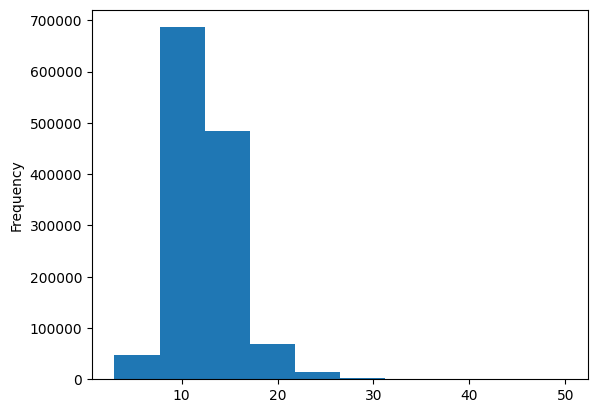

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:

np.percentile(train_df.total_lines,97)

nan

In [ ]:
train_total_lines=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
test_total_lines=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
val_total_lines=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
train_total_lines

c:\Users\Garvit\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:6403: RuntimeWarning: invalid value encountered in cast
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


<tf.Tensor: shape=(1306364, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_total_lines[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                patience=3,
                                                verbose=1,
                                                restore_best_weights=True) # Number of epochs with no improvement after which training will be stopped.

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                               factor=0.2, # by what factor lr to be reduced
                                               patience=0,
                                               min_lr=0,
                                               verbose=1)

In [ ]:
token_inputs=layers.Input(shape=[],dtype="string")
token_embed=hub_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embed)
token_model=tf.keras.Model(token_inputs,token_outputs)

char_inputs=layers.Input(shape=(1,),dtype="string")
char_vector=char_vectorizer(char_inputs)
char_embedding=char_embed(char_vector)
char_outputs=layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model=tf.keras.Model(char_inputs,char_outputs)

# line number model: for this dense layer kind of acts as a embedding layer, infact embeddings are dense fitted layers only
line_no_inputs=layers.Input(shape=(15,),dtype=tf.float32)
x=layers.Dense(32,activation="relu")(line_no_inputs)
line_no_model=tf.keras.Model(line_no_inputs,x)

# total lines model
total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32)
y=layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model=tf.keras.Model(total_lines_inputs,y)

# combine token and char embeddings
combo_embed=layers.Concatenate(name="char_token")([token_model.output,char_model.output])
z=layers.Dense(256,activation="relu")(combo_embed)
z=layers.Dropout(0.3)(z)

# combine position with combo_embed embeddings
tribrid_embed=layers.Concatenate(name="tribrid")([line_no_model.output,total_lines_model.output,z])
output_layer=layers.Dense(5,activation="softmax")(tribrid_embed)
model5=tf.keras.Model(inputs=[line_no_model.input,total_lines_model.input,token_model.input,char_model.input],outputs=output_layer)

In [ ]:
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 285)         0           ['input_2[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_1[0][0]']          

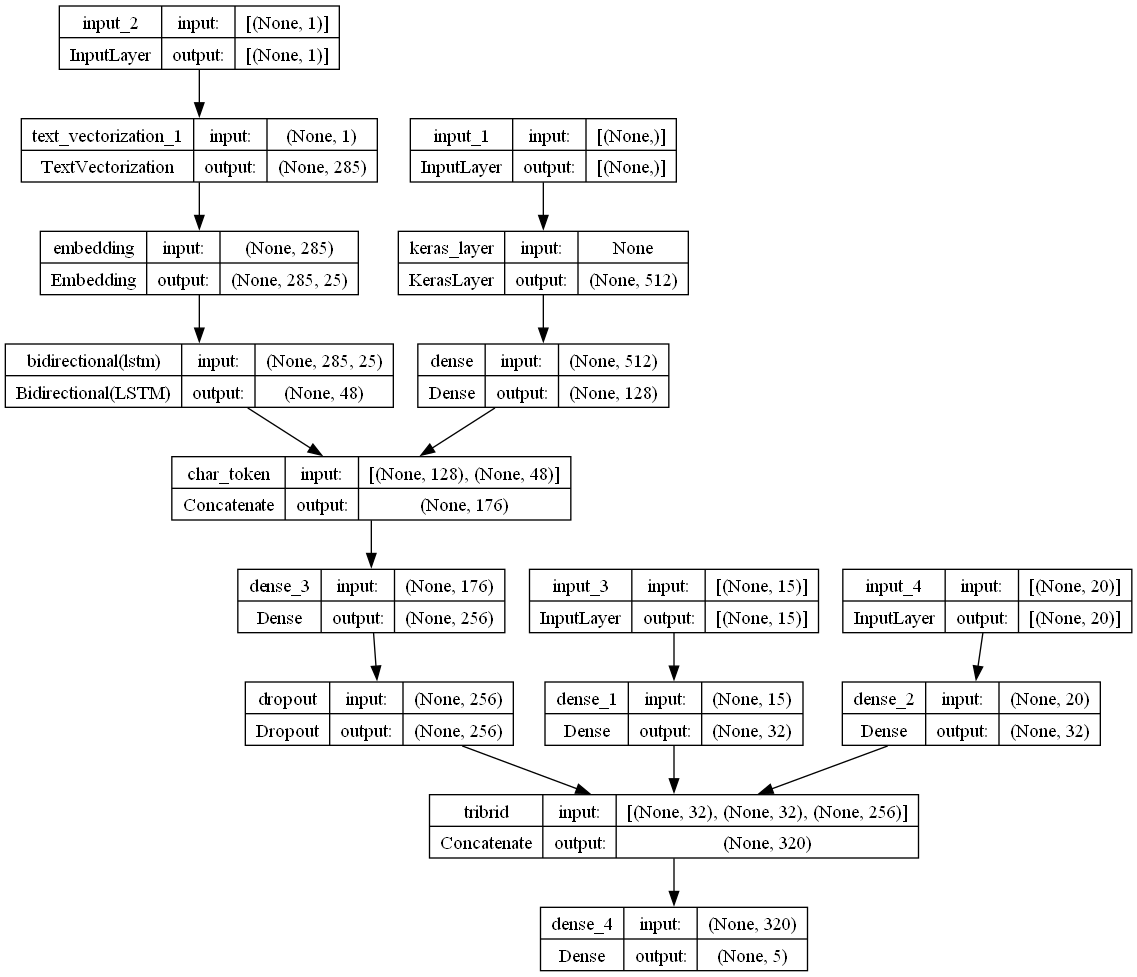

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model5,show_shapes=True)

In [ ]:
for layer in model5.layers:
  print(layer.name, layer.trainable)

input_2 True
input_1 True
text_vectorization_1 True
keras_layer False
embedding True
dense True
bidirectional True
char_token True
input_3 True
input_4 True
dense_3 True
dense_1 True
dense_2 True
dropout True
tribrid True
dense_4 True


In [ ]:
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer="adam",
               metrics=["accuracy"])

>> **This final model of ours has token embedding pretrained and is frozen i.e. it is not updated as the model trains while the character embedding layer is trainable**

>> **Label_smoothing**: When > 0, label values are smoothed, meaning the confidence on label values are relaxed. It is used to reduce overfiting. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample

In [ ]:
train_4_data=tf.data.Dataset.from_tensor_slices((train_line_no,train_total_lines,train_sentences,train_chars))
train_4_labels=tf.data.Dataset.from_tensor_slices(train_label_encoded)
train_4_dataset=tf.data.Dataset.zip((train_4_data,train_4_labels))
train_4_dataset=train_4_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_4_data=tf.data.Dataset.from_tensor_slices((val_line_no,val_total_lines,val_sentences,val_chars))
val_4_labels=tf.data.Dataset.from_tensor_slices(val_label_encoded)
val_4_dataset=tf.data.Dataset.zip((val_4_data,val_4_labels))
val_4_dataset=val_4_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_4_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history5=model5.fit(train_4_dataset,
                    validation_data=val_4_dataset,
                    epochs=50,
                    steps_per_epoch=int(len(train_4_dataset)/32),
                    validation_steps=int(len(val_4_dataset)/32),
                    callbacks=[early_stopping,
                               reduce_lr])

Epoch 1/50


1275/1275 [==============================] - 71s 56ms/step - loss: 0.8597 - accuracy: 0.8862 - val_loss: 0.8893 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 2/50
1274/1275 [============================>.] - ETA: 0s - loss: 0.8890 - accuracy: 0.8630
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1275/1275 [==============================] - 68s 53ms/step - loss: 0.8891 - accuracy: 0.8629 - val_loss: 0.8925 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/50
1275/1275 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.8688
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1275/1275 [==============================] - 57s 44ms/step - loss: 0.8802 - accuracy: 0.8688 - val_loss: 0.8874 - val_accuracy: 0.8650 - lr: 2.0000e-04
Epoch 4/50
1275/1275 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.8692Restoring model weights from the end of the best epoch: 1.

Epoch 4: ReduceLROnPlateau reducing learning 

In [ ]:
model5.save("model5_tribrid1")

INFO:tensorflow:Assets written to: model5_tribrid1\assets


INFO:tensorflow:Assets written to: model5_tribrid1\assets


In [ ]:
import tensorflow as tf
model5=tf.keras.models.load_model("model5_tribrid")

In [ ]:
y_pred5=model5.predict(val_4_dataset)
model5_preds=tf.argmax(y_pred5,axis=1)
model5_results=result(val_label_encode,model5_preds)
model5_results

  1/905 [..............................] - ETA: 35s

905/905 [==============================] - 20s 22ms/step


{'accuracy': 86.95562007465782,
 'precision': 0.8687031910303983,
 'reacall': 0.8695562007465781,
 'f1-score': 0.8680906173759929}

In [ ]:
# compare model results
compare=pd.DataFrame({
    "baseline_model":model0_results,
    "model1_custom_token_embedding":model1_results,
    "model2_pretrained_token_embedding":model2_results,
    "model3_custom_char_embedding":model3_results,
    "model4_hybrid_embedding":model4_results,
    "model5_tribrid_embedding":model5_results
})
compare=compare.transpose()
compare

,accuracy,precision,reacall,f1-score
baseline_model,74.975805,0.743197,0.749758,0.738957
model1_custom_token_embedding,83.647864,0.839547,0.836479,0.834422
model2_pretrained_token_embedding,77.630306,0.773692,0.776303,0.773883
model3_custom_char_embedding,72.708420,0.722852,0.727084,0.716599
model4_hybrid_embedding,77.595742,0.773836,0.775957,0.772456
model5_tribrid_embedding,86.955620,0.868703,0.869556,0.868091


In [ ]:
compare["accuracy"]=compare["accuracy"]/100

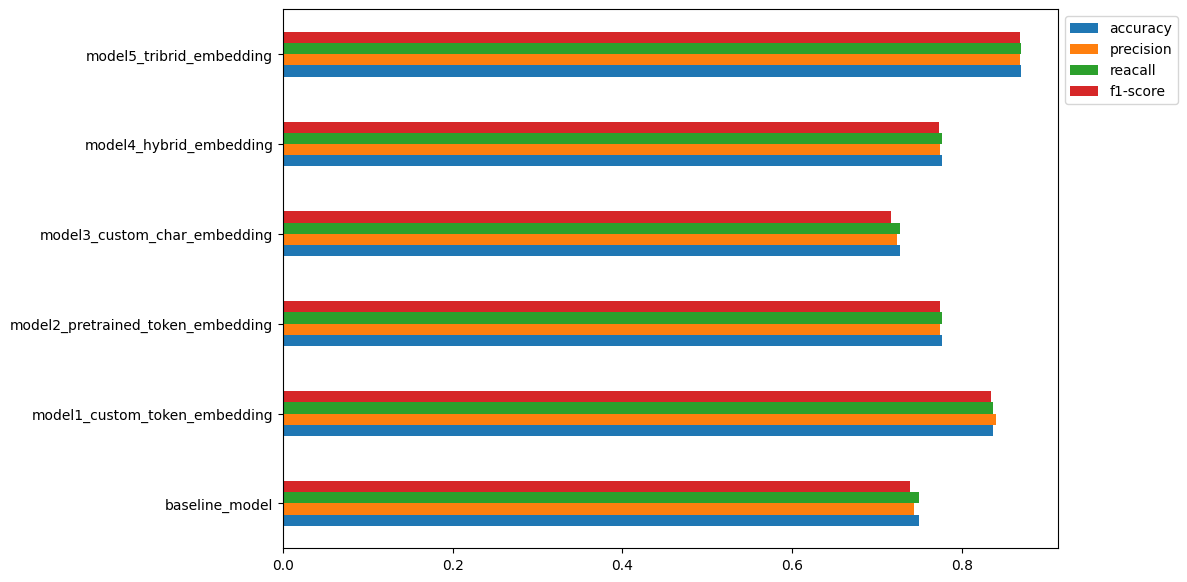

In [ ]:
compare.plot(kind="barh",figsize=(10,7)).legend(bbox_to_anchor=(1,1)) # to set legend out of the plot

<Axes: >

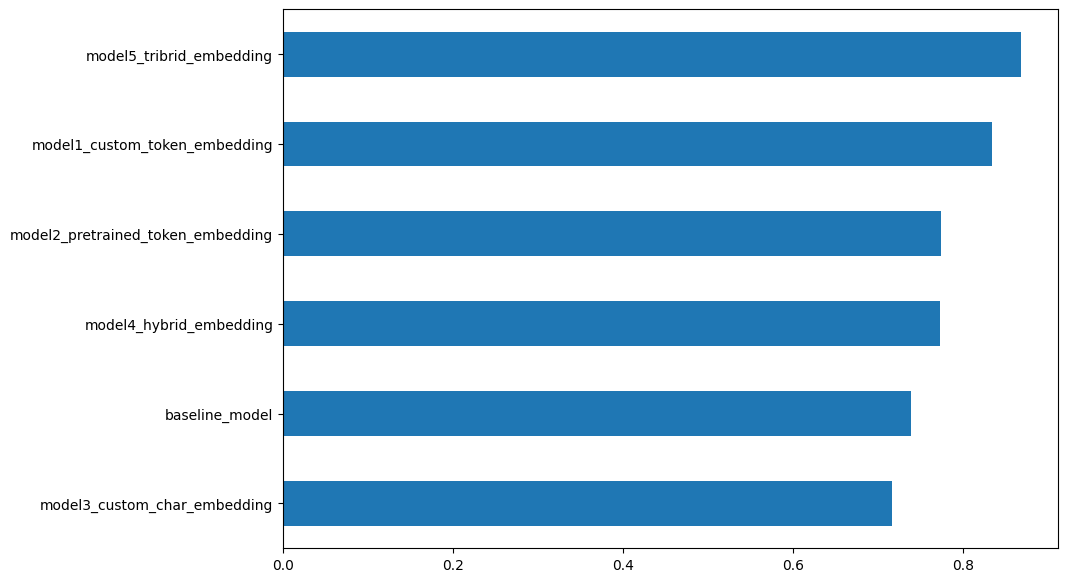

In [ ]:
compare.sort_values("f1-score",ascending=True)["f1-score"].plot(kind="barh",figsize=(10,7))

>> ### Evaluating model on test data

In [ ]:
test_4_data=tf.data.Dataset.from_tensor_slices((test_line_no,test_total_lines,test_sentences,test_chars))
test_4_labels=tf.data.Dataset.from_tensor_slices(test_label_encoded)
test_4_dataset=tf.data.Dataset.zip((test_4_data,test_4_labels))
test_4_dataset=test_4_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
y_pred=model5.predict(test_4_dataset)
test_preds=tf.argmax(y_pred,axis=1)
test_results=result(test_label_encode,test_preds)
test_results

922/922 [==============================] - 28s 27ms/step


{'accuracy': 86.6510697453633,
 'precision': 0.8653024521839302,
 'reacall': 0.8665106974536331,
 'f1-score': 0.8648640410578206}

In [ ]:
pred_classes=[encoder.classes_[pred] for pred in test_preds]
pred_classes[:10]

['BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [ ]:
test_df["prediction"]=pred_classes
test_df["pred_prob"]=tf.reduce_max(y_pred,axis=1)
test_df["correct"]=test_df["prediction"]==test_df["target"]
test_df

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,many pathogenic processes and diseases are the...,11,BACKGROUND,0.617274,True
1,1,BACKGROUND,it was recently demonstrated that supraphysiol...,11,BACKGROUND,0.621955,True
2,2,BACKGROUND,"in the present study , we examined the associa...",11,METHODS,0.467497,False
3,3,BACKGROUND,"in addition , we compared plasma levels of map...",11,METHODS,0.657011,False
4,4,METHODS,a total of @ mi patients and @ control persons...,11,RESULTS,0.669695,False
...,...,...,...,...,...,...,...
29488,7,RESULTS,bone loss at the median forearm site was signi...,12,RESULTS,0.873818,True
29489,8,RESULTS,breast tenderness occurred in @ percent of the...,12,RESULTS,0.874368,True
29490,9,RESULTS,vaginal bleeding occurred at some time in @ pe...,12,RESULTS,0.903371,True
29491,10,CONCLUSIONS,in postmenopausal women with low bone density ...,12,CONCLUSIONS,0.803936,True


In [ ]:
top_wrong=test_df[test_df["correct"]==False].sort_values("pred_prob",ascending=False)[:100]
top_wrong

,line_number,target,text,total_lines,prediction,pred_prob,correct
26363,4,RESULTS,the patients in both groups were treated by ch...,17,METHODS,0.923671,False
22266,4,OBJECTIVE,procedure this was a randomized ( @:@ ) contro...,15,METHODS,0.917557,False
17641,4,RESULTS,community based intervention provided by a tea...,14,METHODS,0.915424,False
12358,3,BACKGROUND,a @-mcg / kg intravenous fentanyl bolus ( n = ...,15,METHODS,0.915007,False
1728,4,OBJECTIVE,"the national institute of oncology , budapest ...",21,METHODS,0.914757,False
...,...,...,...,...,...,...,...
9767,3,RESULTS,all patients also received intravenous heparin...,10,METHODS,0.851258,False
14446,4,RESULTS,lipid levels were determined immediately after...,11,METHODS,0.850931,False
21388,2,RESULTS,postprandial gene expression microarray analys...,11,METHODS,0.850774,False
7726,2,RESULTS,"during phase i ( months @ to @ ) , the interve...",11,METHODS,0.850640,False


In [ ]:
for row in top_wrong[:10].itertuples():
  _,line_number,target,text,_,prediction,pred_prob,_=row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: METHODS, Prob: 0.9236710667610168, Line number: 4

Text:
the patients in both groups were treated by chemotherapy , to group b concurrently clodronate @ x @ mg was administered by the oral route .


-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9175574779510498, Line number: 4

Text:
procedure this was a randomized ( @:@ ) controlled trial with two parallel groups , the vaccine and control groups , that included @ participants in bangladesh .


-----

Target: RESULTS, Pred: METHODS, Prob: 0.9154239296913147, Line number: 4

Text:
community based intervention provided by a team consisting of home care advisors who were supervised by a counselor and a psychiatrist , focusing on supporting the caregiver through information on dementia , guidance on behaviour management , a single psychiatric assessment and psychotropic medication if needed .


-----

Target: BACKGROUND, Pred: METHODS, Prob: 0.9150070548057556, Line number: 3

Text:
a @-mcg / kg intravenous fentan